In [1]:
# learn an estimate of the reward function, ie Rhat = f(s,a)

In [241]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import  pickle

In [242]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [243]:
train_data = pd.read_csv('../data/rl_train_data_final_cont.csv')

In [244]:
val_data = pd.read_csv('../data/rl_val_data_final_cont.csv')

In [245]:
test_data = pd.read_csv('../data/rl_test_data_final_cont.csv')

In [246]:
train_data.head()

,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,...,input_total,input_4hourly,output_total,output_4hourly,cumulated_balance,SOFA,SIRS,vaso_input,iv_input,reward
0,0.000000,11,6898241400,1.0,0.902327,0.428571,1.0,0,0,0,...,0.0,0.0,0.000000,0.000000,0.223817,0.500000,0.00,0.0,0.0,0.383136
1,0.222560,11,6898255800,1.0,0.902327,0.428571,1.0,0,0,0,...,0.0,0.0,0.574861,0.707254,0.223281,0.416667,0.00,0.0,0.0,-0.546041
2,0.356608,11,6898270200,1.0,0.902327,0.428571,1.0,0,0,0,...,0.0,0.0,0.629131,0.723746,0.222629,0.416667,0.25,0.0,0.0,-0.884898
3,0.452837,11,6898284600,1.0,0.902327,0.428571,1.0,0,0,0,...,0.0,0.0,0.659814,0.726688,0.221953,0.458333,0.25,0.0,0.0,-0.025000
4,0.527957,11,6898299000,1.0,0.902327,0.428571,1.0,0,0,0,...,0.0,0.0,0.675701,0.699627,0.221464,0.458333,0.25,0.0,0.0,0.125000


In [247]:
def preproc(df):
    df_in = df.copy()
    keep_arr = list(np.loadtxt('../data/state_features.txt', dtype=str))
    keep_arr.append('iv_input')
    keep_arr.append('vaso_input')
    df_in = df_in[np.abs(df_in['reward']) >=10]
    features = df_in[keep_arr].values
    labels = df_in['reward'].values/15.0
    labels[labels < 0] = 0
    return features,labels

In [248]:
def batch_sample(batch_size, features, labels):
    idx = np.random.choice(np.arange(len(features)), batch_size, replace=False)
    return (np.vstack(features[idx]), labels[idx])

In [249]:
train_feat, train_labels = preproc(train_data)
val_feat, val_labels = preproc(val_data)
test_feat, test_labels = preproc(test_data)

In [250]:
train_feat.shape

(14671, 50)

In [251]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=200,solver='liblinear')
clf.fit(train_feat, train_labels)

LogisticRegression(max_iter=200, solver='liblinear')

In [252]:
# for each state: if not terminal, deterministically get reward. if terminal, use clf to predict outcome,
# and estimated reward = 15 * outcome


In [253]:
feat_names = list(np.loadtxt('../data/state_features.txt', dtype=str))

In [254]:
envmodel_save_dir = './env_model_regression/'
est_state_val = pickle.load(open( envmodel_save_dir + "est_next_states_val.p", "rb" ))
est_state_test =  pickle.load(open( envmodel_save_dir + "est_next_states_test.p", "rb" ))

In [255]:
est_state_val = np.vstack(est_state_val)
est_state_test = np.vstack(est_state_test)

In [256]:
est_state_val.shape

(27813, 48)

In [257]:
# Get the relevant fields from the estimated next states
lact_index = feat_names.index('Arterial_lactate')
sofa_index = feat_names.index('SOFA')

val_data['est_lactate'] = est_state_val[:, lact_index]
val_data['est_sofa'] = est_state_val[:, sofa_index]

test_data['est_lactate'] = est_state_test[:, lact_index]
test_data['est_sofa'] = est_state_test[: , sofa_index]

In [258]:
# undo the scaling on the next state prediction in order to calculate the reward
# unscaled = std_dev*(min_max_normalised*(max_norm - min_norm)) + mean

df_orig = pd.read_csv('../data/discretised_input_data.csv')
df_orig_train = df_orig.loc[df_orig['icustayid'].isin(train_data['icustayid'])]

sofa_mean = df_orig_train['SOFA'].mean()
sofa_std = df_orig_train['SOFA'].std()
lact_mean = df_orig_train['Arterial_lactate'].mean()
lact_std = df_orig_train['Arterial_lactate'].std()
print(sofa_mean,sofa_std,lact_mean,lact_std)
norm_sofa = (df_orig_train['SOFA'] - sofa_mean)/sofa_std
norm_lact = (df_orig_train['Arterial_lactate']-lact_mean)/lact_std

min_norm_sofa = min(norm_sofa)
max_norm_sofa = max(norm_sofa)

min_norm_lact = min(norm_lact)
max_norm_lact = max(norm_lact)

min_max_norm_sofa = (norm_sofa - min_norm_sofa)/(max_norm_sofa-min_norm_sofa)
min_max_norm_lact = (norm_lact - min_norm_lact)/(max_norm_lact-min_norm_lact)

6.289113193943764 3.488883976030776 2.051803343660675 1.6982470951614559


In [259]:
# Add in the agent actions to both the validation and test dataframes
agent_actions_test = pickle.load(open('../continuous/dqn_normalT/dqn_normal_actions_test.p', "rb" ))
agent_actions_val = pickle.load(open('../continuous/dqn_normalT/dqn_normal_actions_val.p', "rb" ))

In [260]:
# unpack the actions into tuples of (iv,vaso)
inv_action_map = {}
count = 0
for i in range(5):
    for j in range(5):
        inv_action_map[count] = [i,j]
        count += 1

In [261]:
# unpack the actions into tuples of (iv,vaso)
test_actions_arr = np.array([inv_action_map[i] for i in agent_actions_test])
val_actions_arr = np.array([inv_action_map[i] for i in agent_actions_val])

In [262]:
val_data['agent_iv'] = val_actions_arr[:,0]
val_data['agent_vaso'] = val_actions_arr[:,1]

test_data['agent_iv'] = test_actions_arr[:,0]
test_data['agent_vaso'] = test_actions_arr[:,1]

In [285]:
# Run the reward estimator
# Some constants taken from preproc/new_rewards:
c0 = -0.1/4
c1 = -0.5/4
c2 = -2
clf_features = list(np.loadtxt('../data/state_features.txt', dtype=str))
clf_features.append('agent_iv')
clf_features.append('agent_vaso')
acc = []

def reward_estimator(df):
    df['unscaled_sofa_now'] = sofa_std*(df['SOFA']*(max_norm_sofa - min_norm_sofa) + min_norm_sofa) + sofa_mean
    df['unscaled_sofa_next'] = sofa_std*(df['est_sofa']*(max_norm_sofa - min_norm_sofa) + min_norm_sofa) + sofa_mean

    df['unscaled_lact_now'] = lact_std*(df['Arterial_lactate']*(max_norm_lact - min_norm_lact) + min_norm_lact) + lact_mean
    df['unscaled_lact_next'] = lact_std*(df['est_lactate']*(max_norm_lact - min_norm_lact) + min_norm_lact) + lact_mean
    rewards = []
    for count,i in enumerate(df.index):
        if count == len(df) - 1 or df.loc[i, 'icustayid'] != df.loc[df.index[count+1], 'icustayid']:
            feat = df.loc[i,clf_features].values
            feat = feat.reshape(1,-1)
            est_outcome = clf.predict(feat)
            acc.append(est_outcome)
            try:
                if est_outcome == 0:
                    rewards.append(-15)
                else:
                    rewards.append(15)
            except ValueError:
                print (est_outcome)
                print (len(est_outcome))
                raise
        else:
            lact_now = df.loc[i, 'unscaled_lact_now']
            sofa_now = df.loc[i, 'unscaled_sofa_now']
            lact_next = df.loc[i, 'unscaled_lact_next']
            sofa_next = df.loc[i, 'unscaled_sofa_next']
            reward = 0
            if sofa_next == sofa_now and sofa_next != 0:
                reward += c0
            reward += c1*(sofa_next-sofa_now)
            reward += c2*np.tanh(lact_next - lact_now)
            rewards.append(reward)
    return np.array(rewards)

In [286]:
test_rewards = reward_estimator(test_data)

In [287]:
# sum =0
# for i in range(len(val_labels)):
#     if np.array(acc)[i] ==test_labels[i]:
#         sum+=1
# print(sum/len(test_labels))

In [288]:
test_data.head()

,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,...,iv_input,reward,est_lactate,est_sofa,agent_iv,agent_vaso,unscaled_sofa_now,unscaled_sofa_next,unscaled_lact_now,unscaled_lact_next
0,0.000000,3,7245486000,0.0,0.412568,0.0,0.0,0,0,1,...,2.0,-1.349270,0.055830,0.136176,1,0,3.0,3.268225,1.180000,1.635808
1,0.222560,3,7245500400,0.0,0.412568,0.0,0.0,0,0,1,...,2.0,1.640796,0.063470,0.263395,1,0,7.0,6.321482,1.633333,1.859663
2,0.356608,3,7245514800,0.0,0.412568,0.0,0.0,0,0,1,...,2.0,-0.025000,0.054041,0.184210,3,0,5.0,4.421038,0.775000,1.583412
3,0.452837,3,7245529200,0.0,0.412568,0.0,0.0,0,0,1,...,2.0,-0.025000,0.054900,0.184409,3,0,5.0,4.425819,0.775000,1.608580
4,0.527957,3,7245543600,0.0,0.412568,0.0,0.0,0,0,1,...,2.0,-0.025000,0.054422,0.187244,3,0,5.0,4.493850,0.775000,1.594555


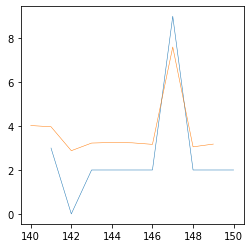

In [289]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1, 1, 1)
d1 = test_data['unscaled_sofa_now'][141:151]
d2 = test_data['unscaled_sofa_next'][140:150]
ax.plot(d1, linewidth = 0.5,label='SAC+AE')  # 画x-y的值，颜色红 olive goldenrod
ax.plot(d2, linewidth = 0.5, label='QHM+CURL(ours)')  # 画x-y的值，颜色红 olive goldenrod

In [290]:
val_rewards = reward_estimator(val_data)


In [291]:
with open(r"val_rewards.p", "wb") as f:
    pickle.dump(val_rewards, f)

In [292]:
with open(r"test_rewards.p", "wb") as f:
    pickle.dump(test_rewards, f)